## PART II. Data Cleaning

### Objective

Based strictly on the conclusions established in **PART I: Data Profiling and Preprocessing Decisions**,  
this section implements the data cleaning pipeline.

All cleaning operations follow a **governance-driven strategy**, where:
- Missing value handling is guided by missingness categories,
- Format issues are corrected without altering semantic meaning,
- Systematic missingness is preserved as informative signal,
- Over-cleaning and unjustified assumptions are avoided.

The cleaned dataset will serve as the input for **Part III: Feature Engineering**.

### Cleaning Principles Derived from Part I

| Missing Category | Interpretation | Cleaning Strategy |
|-----------------|---------------|------------------|
| Fully missing | No usable information | Drop feature |
| Systematic missing | Meaningful absence | Preserve missing values |
| Moderate missing | Informative but incomplete | Type-aware, selective imputation |
| Low missing | Minor data loss | Conservative imputation |

This separation ensures consistency with the CRISP-DM framework and prevents semantic distortion.

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

sns.set(style="whitegrid")

df = pd.read_csv("../data/listings.csv")

print("Initial dataset shape:", df.shape)


Initial dataset shape: (3693, 79)


### Duplicate Verification

According to **Part I**, no fully duplicated rows or duplicated listing IDs were detected.
This step is included for verification and documentation consistency only.
No deduplication is performed.


Duplicated rows: 0
Duplicated listing IDs: 0


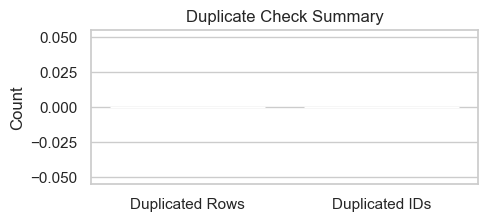

In [72]:
dup_rows = df.duplicated().sum()
dup_ids = df["id"].duplicated().sum()

print("Duplicated rows:", dup_rows)
print("Duplicated listing IDs:", dup_ids)

plt.figure(figsize=(5, 2))
sns.barplot(x=["Duplicated Rows", "Duplicated IDs"], y=[dup_rows, dup_ids])
plt.title("Duplicate Check Summary")
plt.ylabel("Count")
plt.show()


### Removal of Fully Missing Features

The following feature was identified in Part I as **100% missing** and contains no usable information:

- `calendar_updated`

As a result, this feature is removed from the dataset.

In [73]:
df = df.drop(columns=["calendar_updated"])
print("Removed fully missing feature: calendar_updated")

Removed fully missing feature: calendar_updated


### Data Type Conversion and Format Cleaning

Several variables exhibit format inconsistencies rather than semantic errors.
These are corrected to enable numerical analysis while preserving the original data meaning.

Key cases include:
- `price`: stored as a string with currency symbols,
- percentage-based host response metrics.

In [74]:
df["price"] = (
    df["price"]
    .astype(str)
    .str.replace(r"[\$,]", "", regex=True)
)
df["price"] = pd.to_numeric(df["price"], errors="coerce")

print("Price column converted to numeric.")


Price column converted to numeric.


These two columns are percentage-based metrics, stored as strings with a `%` symbol (e.g., `"95%"`).
To use them as numeric features in analysis or modeling, we need to:

1. Remove the `%` symbol.
2. Convert the values to numeric type (float or int).

Other columns are not percentages stored as strings, so they don’t require this conversion.

In [75]:
for col in ["host_response_rate", "host_acceptance_rate"]:
    if col in df.columns:
        df[col] = (
            df[col].astype(str)
            .str.replace("%", "")
        )
        df[col] = pd.to_numeric(df[col], errors="coerce")

print("Host response and acceptance rates parsed.")


Host response and acceptance rates parsed.


### Post-cleaning Price Distribution

As established in Part I, listing prices follow a **long-tailed distribution**.
Extreme values are treated as structural characteristics rather than outliers.

Therefore, no price-based filtering is applied.
A log-scale visualization is used to validate the distribution after parsing.


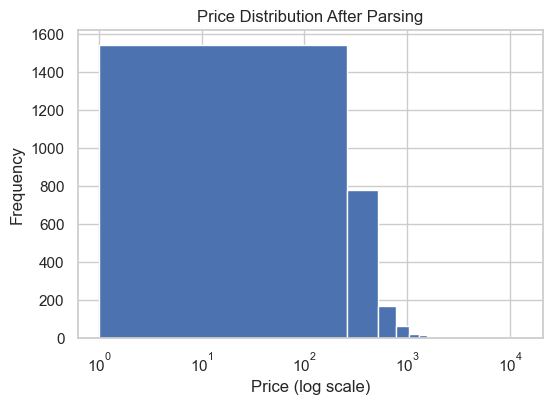

In [76]:
plt.figure(figsize=(6, 4))
df["price"].dropna().hist(bins=50)
plt.xscale("log")
plt.xlabel("Price (log scale)")
plt.ylabel("Frequency")
plt.title("Price Distribution After Parsing")
plt.show()


### Parsing Unstructured Bathroom Information

The `bathrooms` column exhibits moderate missingness.
However, relevant numeric information is embedded in `bathrooms_text`.

A regular-expression-based parser is used to extract the numeric bathroom count.
The original text field is retained.

In [77]:
def parse_bathrooms(text):
    match = re.search(r"(\d+(\.\d+)?)", str(text))
    return float(match.group(1)) if match else np.nan

if "bathrooms_text" in df.columns:
    df["bathrooms"] = df["bathrooms_text"].apply(parse_bathrooms)

df[["bathrooms_text", "bathrooms"]].head()



,bathrooms_text,bathrooms
0,1 private bath,1.0
1,Shared half-bath,NaN
2,Shared half-bath,NaN
3,2 shared baths,2.0
4,2.5 shared baths,2.5


### Classify Missing Values

We calculate missing percentages for all columns and classify them as:

- Fully missing: 100% missing → already dropped
- Systematic missing: 45%–80%
- Moderate missing: 20%–45%
- Low missing: <20%


In [78]:
missing_pct = df.isnull().mean() * 100

fully_missing_cols = missing_pct[missing_pct == 100].index.tolist()
df.drop(columns=fully_missing_cols, inplace=True)
print("Dropped fully missing columns:", fully_missing_cols)

# Systematic missing: 45-80%
systematic_cols = missing_pct[(missing_pct >= 45) & (missing_pct < 80)].index.tolist()
print("Systematic missing columns:", systematic_cols)

# Moderate missing: 20-45%
moderate_cols = missing_pct[(missing_pct >= 20) & (missing_pct < 45)].index.tolist()
print("Moderate missing columns:", moderate_cols)

# Low missing: <20%
low_cols = missing_pct[missing_pct < 20].index.tolist()
low_cols = [col for col in low_cols if col not in fully_missing_cols + systematic_cols + moderate_cols]
print("Low missing columns:", low_cols)

# Summary table
missing_summary = pd.DataFrame({
    "Missing_Percentage": missing_pct,
    "Category": ["Fully Missing" if col in fully_missing_cols
                 else "Systematic Missing" if col in systematic_cols
                 else "Moderate Missing" if col in moderate_cols
                 else "Low Missing" for col in df.columns]
})
display(missing_summary.sort_values("Missing_Percentage", ascending=False))


Dropped fully missing columns: []
Systematic missing columns: ['neighborhood_overview', 'neighbourhood', 'first_review', 'last_review', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'reviews_per_month']
Moderate missing columns: ['host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'beds', 'price', 'estimated_revenue_l365d', 'license']
Low missing columns: ['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name', 'description', 'picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'property_type',

,Missing_Percentage,Category
neighbourhood,53.425399,Systematic Missing
neighborhood_overview,53.425399,Systematic Missing
review_scores_location,50.013539,Systematic Missing
review_scores_value,50.013539,Systematic Missing
reviews_per_month,49.986461,Systematic Missing
...,...,...
accommodates,0.000000,Low Missing
listing_url,0.000000,Low Missing
minimum_nights,0.000000,Low Missing
maximum_nights,0.000000,Low Missing


### Systematic Missingness Handling

Systematic missing columns are preserved as informative features:

- `reviews_per_month`: fill missing with 0 (no reviews)
- Other systematic missing columns: create a missing indicator column


In [79]:
if "reviews_per_month" in df.columns:
    df["reviews_per_month"] = df["reviews_per_month"].fillna(0)

for col in systematic_cols:
    if col != "reviews_per_month":
        df[col + "_missing"] = df[col].isnull().astype(int)


### Moderate Missingness Handling

Moderate missing features are handled carefully:

- Numerical columns: filled with median, optionally grouped by `room_type`.
- Textual columns: filled with `"Unknown"`.
- Derived numeric metrics (e.g., revenue estimates): filled with 0.


In [80]:
moderate_num = [col for col in moderate_cols if df[col].dtype in ["int64","float64"]]
moderate_obj = [col for col in moderate_cols if df[col].dtype == "object"]

# Numeric: fill median
for col in moderate_num:
    if "room_type" in df.columns:
        df[col] = df.groupby("room_type")[col].transform(lambda x: x.fillna(x.median()))
    else:
        df[col] = df[col].fillna(df[col].median())

# Object: fill placeholder
for col in moderate_obj:
    if col in ["estimated_revenue_l365d"]:
        df[col] = df[col].fillna(0)
    else:
        df[col] = df[col].fillna("Unknown")


### Low Missingness Handling

Low missing features (<20%) are handled conservatively:

- Numeric: median
- Categorical: `"Unknown"`


In [81]:
for col in low_cols:
    if df[col].dtype in ["int64","float64"]:
        df[col] = df[col].fillna(df[col].median())
    else:
        df[col] = df[col].fillna("Unknown")


### Post-cleaning Missingness Audit

Visualize the remaining missing values to ensure cleaning is complete.


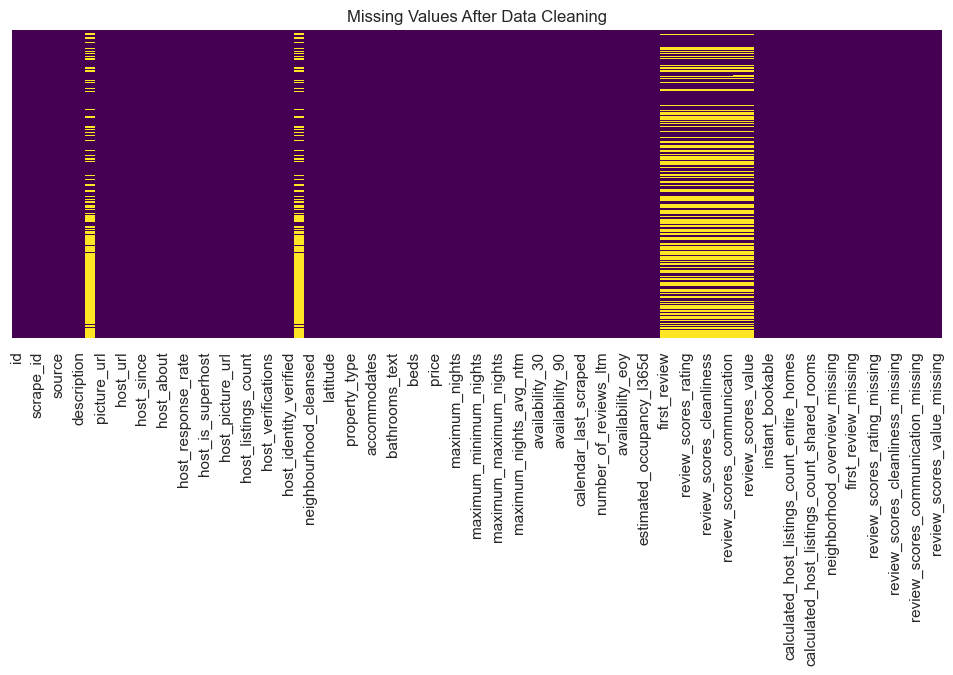

In [82]:
plt.figure(figsize=(12, 4))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis') 
plt.title("Missing Values After Data Cleaning")
plt.show()


### Output

The cleaned dataset is saved and used as input for **Part III: Feature Engineering**.


In [83]:
df.to_csv("../data/listings_cleaned.csv", index=False)
print("✅ listings_cleaned.csv saved successfully.")


✅ listings_cleaned.csv saved successfully.
